In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Inspect the columns

In [10]:
# Check all the columns present in Measurement Table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [11]:
# Check all the columns present in Station Table
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for column in columns:
    print(column)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


# Get the date corresponding to 1 year before the last date available

In [12]:
# Get the last date in the measurement table
last_data_date = max(session.query(Measurement.date))[0]

# Grab the year, month and day and convert them to integer so that it can be used in datetime function
year = int(last_data_date[:4])
month = int(last_data_date[5:7])
day = int(last_data_date[8:10])

one_year_ago = year-1 # Starting date is one year from the last date

# Calculate the date 1 year ago from the last data point in the database
beginning_date = dt.datetime(one_year_ago,month,day)

In [13]:
#measurement_table = session.query(Measurement)
#station_table = session.query(Station)
print(beginning_date)

2016-08-23 00:00:00


# Precipitation Analysis

In [14]:
# Perform a query to retrieve the data and precipitation scores
prcp_table = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=beginning_date).all()

In [15]:
# instantiate empty list to hold date and precipitation

date_m = []
prcp_m = []

for record in prcp_table:
    date_m.append(record.date)
    prcp_m.append(record.prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column    
measurement_df = pd.DataFrame(columns=['date','prcp'])
measurement_df.date = date_m
measurement_df.prcp = prcp_m

#measurement_df.set_index('date',inplace = True)

# Sort the dataframe by date
measurement_df.sort_values('date',ascending = False, inplace = True)
measurement_df.head()

date  prcp
2222  2017-08-23  0.45
1523  2017-08-23  0.08
1005  2017-08-23  0.00
359   2017-08-23  0.00
1522  2017-08-22  0.00

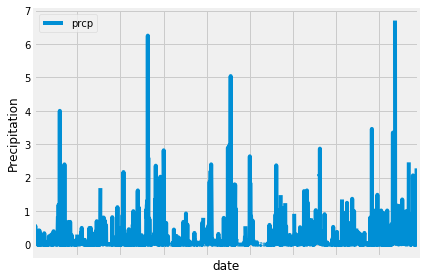

In [16]:
#plt.bar(measurement_df['date'], measurement_df['prcp'])
measurement_df.plot(x='date',y='prcp')

plt.ylabel('Precipitation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tight_layout()
plt.savefig('Images/Date_vs_Precipation.png')
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
description_df = pd.DataFrame(measurement_df['prcp'].describe())
description_df

prcp
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

# Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
station_table = session.query(Station).count()
print(station_table)

9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


session.query(Measurement.station , func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperature_details = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
.filter(Measurement.station == 'USC00519281')

print(temperature_details[0])


(54.0, 85.0, 71.66378066378067)


In [21]:
# Choose the station with the highest number of temperature observations.
station_highest_number_temp_obs = session.query(Measurement.station , func.count(Measurement.tobs)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()

print(station_highest_number_temp_obs[0])
print(station_highest_number_temp_obs[1])

USC00519281
2772


In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_table = session.query(Measurement.date,Measurement.tobs).\
filter(Measurement.date>=beginning_date).\
filter(Measurement.station == 'USC00519281').all()


In [23]:
# instantiate empty list to hold date and temperature

date_t = []
temperature_t = []

for record in temp_table:
    date_t.append(record.date)
    temperature_t.append(record.tobs)

# Save the query results as a Pandas DataFrame and set the index to the date column    
temp_df = pd.DataFrame(columns=['date','temp'])
temp_df.date = date_t
temp_df.temp = temperature_t

#measurement_df.set_index('date',inplace = True)

# Sort the dataframe by date
temp_df.sort_values('date',ascending = False, inplace = True)
temp_df.head()


date  temp
350  2017-08-18  79.0
349  2017-08-17  76.0
348  2017-08-16  76.0
347  2017-08-15  77.0
346  2017-08-14  77.0

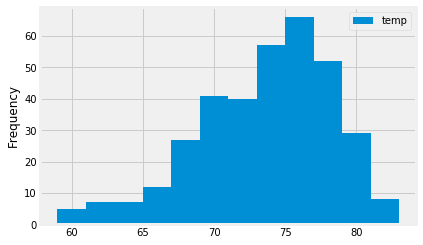

In [24]:
# plot the histogram

temp_df.plot(x='date', y='temp',kind='hist', bins=12 )
plt.savefig('Images/date vs tempFrequency.png')
plt.show()

# Step 2 - Climate App

* Please run 'ClimateApp.py' available in the same folder